In [1]:
import pandas as pd 
import numpy as np 
import pickle 
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
cells_params_30D= pd.read_parquet('/data/u_AA/throughput_opt/cells_30D_parameters_new_KPI.parquet')

In [3]:
cells_params_30D.head()

DATE_ID  HOUR_ID                CELL_NAME  DL_TRAFFIC_GB  \
0  29-MAR-24 00.00.00       20  LCAI1993_19932_R_H_D6_2         0.3465   
1  29-MAR-24 00.00.00       15  LCAI1993_19933_N_H_D6_3         9.4344   
2  29-MAR-24 00.00.00        0  LCAI1993_19934_N_H_D6_4         2.1060   
7  29-MAR-24 00.00.00        3  LCAI1993_37372_S_H_D6_2         2.2151   
8  29-MAR-24 00.00.00       20  LCAI1993_37375_U_H_D6_2         0.3858   

   DL_THROUGHPUT  UL_THROUGHPUT  UL_TRAFFIC_GB  DL_PRB_UTI  CCE_UTI  \
0         7.4068         1.5237         0.0304      11.996    17.05   
1        12.3100         0.6579         0.5160      80.318    40.87   
2        12.5476         1.9003         0.2050      33.318    25.33   
7         9.9699         1.8646         0.1141      34.957    30.13   
8         9.7426         2.3282         0.0406       9.645    14.74   

   VOLTE_DL_TRAFFIC_ERL  VOLTE_DL_TRAFFIC_MB  VOLTE_UL_TRAFFIC_MB  \
0                  0.74                 4.72                 5.72   
1                 11.01                62.30                65.00   
2                  6.46                34.23                41.24   
7                  1.59                 9.39                11.58   
8                  1.33                 7.89                10.42   

   AVG_ACTIVE_UE_DL  PRB_DL_AVAILABLE  CQI_AVERAGE  MIMO_RANK_2_PERCENTAGE  \
0             4.789              89.0         5.73                    1.92   
1            66.976              95.0         8.90                   38.45   
2            26.423              93.0         6.86                   34.22   
7            13.941              89.0         6.92                    9.63   
8             5.332              89.0         7.68                   17.36   

   MIMO_RANK_3_PERCENTAGE  MIMO_RANK_4_PERCENTAGE MAXMIMORANKPARA  \
0                    0.00                    0.00            None   
1                    0.03                    0.01            None   
2                    0.39                    0.00            None   
7                    0.00                    0.00            None   
8                    0.00                    0.00            None   

   REFERENCESIGNALPWR  MAXIMUM_TRANSMIT_POWER band band_letter  
0                 NaN                     NaN   D6           D  
1                 NaN                     NaN   D6           D  
2                 NaN                     NaN   D6           D  
7                 NaN                     NaN   D6           D  
8                 NaN                     NaN   D6           D

In [4]:
cells_params_30D.groupby(['PRB_DL_AVAILABLE','band_letter']).size()

PRB_DL_AVAILABLE  band_letter
50.0              D                 138
60.0              D                  30
63.0              D                 118
70.0              D                  60
72.0              D                  30
75.0              D               37984
80.0              D                  24
81.0              D                  61
82.0              D                   2
83.0              D                  51
84.0              D               95434
85.0              D                1607
86.0              D                8902
87.0              D               14172
88.0              D               31894
89.0              D               12952
90.0              D               73081
91.0              D               24495
92.0              D               39191
93.0              D               17541
94.0              D               41874
95.0              D               56710
96.0              D               24081
97.0              D               16976
98.0      

In [4]:
cells_params_30D.PRB_DL_AVAILABLE.value_counts().sort_index()

50.0        138
60.0         30
63.0        118
70.0         60
72.0         30
75.0      37984
80.0         24
81.0         61
82.0          2
83.0         51
84.0      95434
85.0       1607
86.0       8902
87.0      14172
88.0      31894
89.0      12952
90.0      73081
91.0      24495
92.0      39191
93.0      17541
94.0      41874
95.0      56710
96.0      24081
97.0      16976
98.0      24905
99.0      25755
100.0    439695
Name: PRB_DL_AVAILABLE, dtype: int64

In [5]:
test_group=cells_params_30D[cells_params_30D['band_letter']=='T']

In [6]:
test_group.PRB_DL_AVAILABLE.value_counts()

100.0    368201
Name: PRB_DL_AVAILABLE, dtype: int64

In [7]:
test_group.dropna(subset=['REFERENCESIGNALPWR','MAXIMUM_TRANSMIT_POWER'],inplace=True)
test_group.MAXMIMORANKPARA.fillna('Rank2',inplace=True)

/Datascience/linux/Anaconda3/envs/torch/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Datascience/linux/Anaconda3/envs/torch/lib/python3.7/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [8]:
test_group=test_group[test_group['CQI_AVERAGE'].notna()]
test_group=test_group[test_group['AVG_ACTIVE_UE_DL'].notna()]
test_group=test_group[test_group['PRB_DL_AVAILABLE'].notna()]
test_group=test_group[((test_group['PRB_DL_AVAILABLE']>=70)&(test_group['PRB_DL_AVAILABLE']<=100))]
test_group=test_group[~((test_group['REFERENCESIGNALPWR']<0 )|(test_group['MAXIMUM_TRANSMIT_POWER']==65535))]

In [9]:
test_group.shape

(286095, 23)

In [ ]:
test_group.to_csv('/data/u_AA/throughput_opt/group_T_prb_100.csv',index=False)

In [8]:
test_group.head()

DATE_ID  HOUR_ID                CELL_NAME  DL_TRAFFIC_GB  \
30  29-MAR-24 00.00.00       23  LCAI2006_39842_N_H_T4_2         6.2106   
31  29-MAR-24 00.00.00        7  LCAI2006_39843_N_H_T4_3         3.3086   
32  29-MAR-24 00.00.00       13  LCAI2006_39844_N_H_T4_4         3.5287   
33  29-MAR-24 00.00.00       20  LCAI2006_39847_N_H_T8_2         3.4496   
34  29-MAR-24 00.00.00       20  LCAI2006_39848_N_H_T8_3         1.9185   

    DL_THROUGHPUT  UL_THROUGHPUT  UL_TRAFFIC_GB  DL_PRB_UTI  CCE_UTI  \
30         4.8313         2.5944         0.5875      74.422    27.44   
31         8.1491         2.0963         0.1265      58.455    17.80   
32         7.4628         1.8924         0.1849      66.575    21.45   
33         4.4452         2.2935         0.3777      58.071    24.99   
34         5.0429         3.4162         0.4507      40.831    19.74   

    VOLTE_DL_TRAFFIC_ERL  VOLTE_DL_TRAFFIC_MB  VOLTE_UL_TRAFFIC_MB  \
30                  0.76                 9.40                10.94   
31                  0.00                 0.03                 0.06   
32                  0.13                 1.39                 1.63   
33                  0.67                 8.16                 9.05   
34                  0.27                 4.34                 4.97   

    AVG_ACTIVE_UE_DL  PRB_DL_AVAILABLE  CQI_AVERAGE  MIMO_RANK_2_PERCENTAGE  \
30            92.019             100.0         9.86                   42.21   
31            14.266             100.0        10.13                   26.61   
32            29.972             100.0        10.55                   15.78   
33            76.220             100.0         9.44                   35.49   
34            31.570             100.0         8.93                   24.48   

    MIMO_RANK_3_PERCENTAGE  MIMO_RANK_4_PERCENTAGE MAXMIMORANKPARA  \
30                    0.21                     0.0           Rank2   
31                    0.70                     0.0           Rank2   
32                    0.03                     0.0           Rank2   
33                    0.08                     0.0           Rank2   
34                    0.01                     0.0           Rank2   

    REFERENCESIGNALPWR  MAXIMUM_TRANSMIT_POWER band band_letter  
30               152.0                   430.0   T4           T  
31               152.0                   430.0   T4           T  
32               152.0                   430.0   T4           T  
33               152.0                   430.0   T8           T  
34               152.0                   430.0   T8           T

Text(0.5, 0, 'DL Throughput(Mb)')

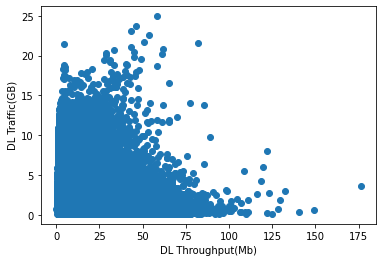

In [12]:
plt.scatter(test_group.DL_THROUGHPUT,test_group.DL_TRAFFIC_GB)
plt.ylabel("DL Traffic(GB)")
plt.xlabel("DL Throughput(Mb)")

In [13]:
X = test_group.DL_THROUGHPUT
y = test_group.DL_TRAFFIC_GB

In [14]:
X.describe()

count    286095.000000
mean         12.684319
std           9.514144
min           0.000000
25%           6.104850
50%           9.976100
75%          16.458150
max         176.062700
Name: DL_THROUGHPUT, dtype: float64

In [15]:
test_group.describe()

HOUR_ID  DL_TRAFFIC_GB  DL_THROUGHPUT  UL_THROUGHPUT  \
count  286095.000000  286095.000000  286095.000000  286095.000000   
mean       13.235625       3.228844      12.684319       2.235029   
std         8.690904       2.260546       9.514144       1.009216   
min         0.000000       0.100100       0.000000       0.141700   
25%         3.000000       1.439550       6.104850       1.761800   
50%        16.000000       2.819500       9.976100       2.111100   
75%        21.000000       4.608100      16.458150       2.497800   
max        23.000000      24.942200     176.062700      40.768200   

       UL_TRAFFIC_GB     DL_PRB_UTI        CCE_UTI  VOLTE_DL_TRAFFIC_ERL  \
count  286095.000000  286095.000000  286095.000000         286095.000000   
mean        0.259660      41.706208      18.683012              0.480453   
std         0.214387      25.585080       8.984189              0.886898   
min         0.000700       1.401000       2.030000              0.000000   
25%         0.089700      19.881000      11.970000              0.030000   
50%         0.207100      38.523000      17.480000              0.180000   
75%         0.379400      61.626500      23.970000              0.590000   
max         2.902700      99.554000      77.740000             18.210000   

       VOLTE_DL_TRAFFIC_MB  VOLTE_UL_TRAFFIC_MB  AVG_ACTIVE_UE_DL  \
count        286095.000000        286095.000000     286095.000000   
mean              5.681310             5.715958         28.283639   
std              10.870475            11.067423         24.780670   
min               0.000000             0.000000          0.024000   
25%               0.240000             0.220000          9.079000   
50%               1.970000             1.930000         21.817000   
75%               6.800000             6.790000         40.812000   
max             231.040000           270.250000        292.489000   

       PRB_DL_AVAILABLE    CQI_AVERAGE  MIMO_RANK_2_PERCENTAGE  \
count          286095.0  286095.000000           286095.000000   
mean              100.0      10.381047               43.914650   
std                 0.0       1.151863               19.359358   
min               100.0       3.040000                0.000000   
25%               100.0       9.600000               29.980000   
50%               100.0      10.350000               42.240000   
75%               100.0      11.130000               56.450000   
max               100.0      14.990000              100.000000   

       MIMO_RANK_3_PERCENTAGE  MIMO_RANK_4_PERCENTAGE  REFERENCESIGNALPWR  \
count           286095.000000           286095.000000       286095.000000   
mean                 0.265266                0.018872          161.094147   
std                  1.602461                0.289455           14.941574   
min                  0.000000                0.000000           31.000000   
25%                  0.000000                0.000000          152.000000   
50%                  0.010000                0.000000          152.000000   
75%                  0.110000                0.010000          179.000000   
max                 98.400000               71.720000          192.000000   

       MAXIMUM_TRANSMIT_POWER  
count           286095.000000  
mean               446.055377  
std                 16.837884  
min                339.000000  
25%                430.000000  
50%                448.000000  
75%                460.000000  
max                470.000000

In [16]:
test_group=test_group[test_group.DL_THROUGHPUT>0]

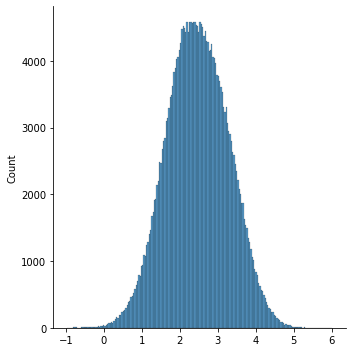

In [17]:
transformed_X, lambda_x = boxcox(test_group.DL_THROUGHPUT) 
sns.displot(transformed_X) 

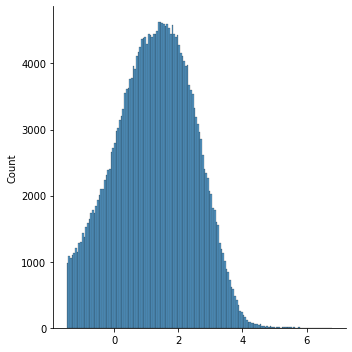

In [18]:
transformed_y, lambda_y = boxcox(test_group.DL_TRAFFIC_GB) 
sns.displot(transformed_y) 

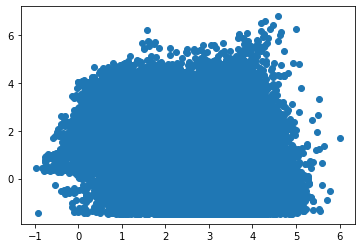

In [19]:
plt.scatter(transformed_X,transformed_y)

In [20]:
transformed_y

array([ 2.74344653,  1.55361753,  1.66140137, ..., -0.4737793 ,
       -0.20326814, -0.36087287])

In [21]:
transformed_X

array([1.64806377, 2.22863183, 2.12971638, ..., 3.08600981, 3.50436255,
       4.5724303 ])

In [22]:
transformed_df=pd.DataFrame()
transformed_df['X']=transformed_X
transformed_df['y']=transformed_y

In [23]:
transformed_df['X']

0         1.648064
1         2.228632
2         2.129716
3         1.557157
4         1.695018
5         1.908461
6         2.547014
7         3.304213
8         2.809710
9         2.192160
10        0.863184
11        2.036233
12        1.509627
13        1.877526
14        2.634101
15        2.653629
16        2.499815
17        2.043916
18        1.890255
19        2.100229
20        2.497052
21        1.946700
22        2.640255
23        1.944540
24        2.893994
25        2.356214
26        1.863207
27        1.901610
28        0.941003
29        1.991817
30        0.988316
31        1.084558
32        1.775204
33        0.697791
34       -0.350973
35        2.589373
36        2.328387
37        2.717047
38        1.344576
39        1.291851
40        0.648169
41        1.756520
42        2.148207
43        2.656495
44        2.100630
45        2.018211
46        1.919947
47        2.855584
48        1.984178
49        2.014673
50        1.345754
51        1.984501
52        2.

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(transformed_df['X'].values, transformed_df['y'].values, test_size=0.2, random_state=42)

# Train a Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

y_pred_linear = linear_regressor.predict(X_test.reshape(-1,1))

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Mean Squared Error:", mse_linear)
print("R-squared:", r2_linear)


Mean Squared Error: 1.0978547486645913
R-squared: 0.2544439090263948


In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
model = xgb.XGBRegressor(eval_metric='rmse',seed=0,eta=0.2,reg_lambda=1,reg_alpha=0.5 )
#model = xgb.XGBRegressor(
model.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
y_predict_test = model.predict(y_test)

In [26]:
mse = mean_squared_error(y_test, y_predict_test)
r2 = r2_score(y_test, y_predict_test)

In [27]:
print("mse: " ,mse)
print("r2_score: " ,r2)

mse:  2.289551577312564
r2_score:  -0.5548405890123034


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(test_group.DL_THROUGHPUT.values,test_group.DL_TRAFFIC_GB.values, test_size=0.2, random_state=42)

# Train a Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

y_pred_linear = linear_regressor.predict(X_test.reshape(-1,1))

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print("Mean Squared Error:", mse_linear)
print("R-squared:", r2_linear)


Mean Squared Error: 4.323019202578583
R-squared: 0.16607737231003183


In [40]:
print(X_test.reshape(-1,1).flatten())

array([1.88283405, 4.18969813, 1.30288015, ..., 3.01275971, 3.50638199,
       2.66071071])

In [45]:

import seaborn as sns
import matplotlib.pyplot as plt
def calculate_residuals(model, X, y):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(X)
   
    df_results = pd.DataFrame({'Actual': y.reshape(-1,1).flatten(), 'Predicted': predictions.reshape(-1,1).flatten()})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    df_results["high_flag"] = df_results.apply(lambda row: row["Actual"] <= row["Predicted"], axis = 1)
    df_results["Error"] = df_results.apply(lambda row:"positive_error" if row["high_flag"] else "negative_error", axis = 1)
    #df_results['band_T']= X['band_T']
    return df_results
def linear_assumption(model, X, y):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, X, y)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7, hue = "Error")
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.iloc[:,:-1].min().min(), df_results.iloc[:,:-1].max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.xlabel('Actual Traffic')
    plt.ylabel('Predicted Traffic')
    plt.show()
    return df_results


Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


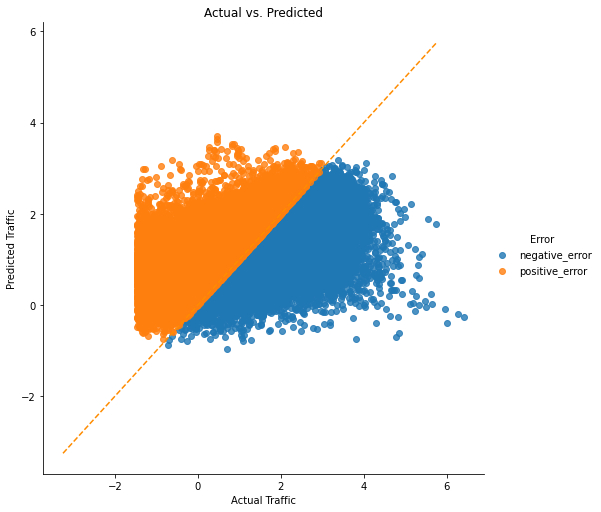

In [46]:
df_results_linear_1= linear_assumption(linear_regressor,X_test.reshape(-1,1), y_test)

In [47]:
df_results_linear_1.describe()

Actual     Predicted     Residuals
count  57219.000000  57219.000000  57219.000000
mean       1.252267      1.250050      0.201088
std        1.213490      0.610952      0.862054
min       -1.476697     -0.957723     -3.250634
25%        0.390780      0.821836     -0.396111
50%        1.294490      1.261467      0.154838
75%        2.145078      1.675753      0.744289
max        6.420222      3.700627      6.162538

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


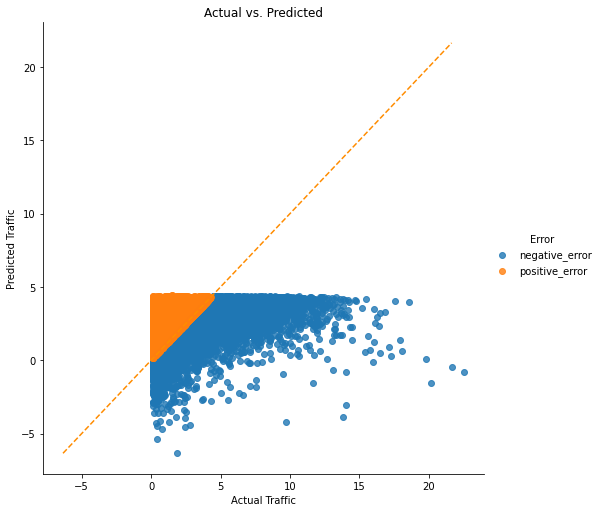

In [49]:
df_results_linear_2= linear_assumption(linear_regressor,X_test.reshape(-1,1), y_test)

In [59]:
df_results_linear_2.describe()

Actual     Predicted     Residuals
count  57219.000000  57219.000000  57219.000000
mean       3.235287      3.225510     -0.012354
std        2.276850      0.930801      2.062110
min        0.100100     -6.349214     -4.956494
25%        1.436050      2.857376     -1.511242
50%        2.812800      3.494439     -0.339929
75%        4.619500      3.869941      1.118858
max       22.553500      4.421200     21.782429

In [54]:
training_df=pd.DataFrame()
training_df['X']=X_train
training_df['y']=y_train
training_df.describe()

X              y
count  228875.000000  228875.000000
mean       12.680809       3.227245
std         9.508574       2.256453
min         0.364900       0.100100
25%         6.107100       1.440500
50%         9.983600       2.821100
75%        16.456000       4.605100
max       176.062700      24.942200

/Datascience/linux/Anaconda3/envs/torch/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y', ylabel='Density'>

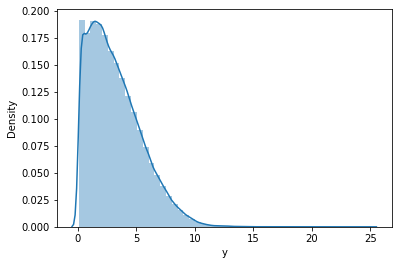

In [56]:
sns.distplot(training_df.y)

In [57]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
model = xgb.XGBRegressor(eval_metric='rmse',seed=0,eta=0.2,reg_lambda=1,reg_alpha=0.5 )
#model = xgb.XGBRegressor(
model.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
y_predict_test = model.predict(y_test.reshape(-1,1))

In [58]:
mse = mean_squared_error(y_test.reshape(-1,1), y_predict_test.reshape(-1,1))
r2 = r2_score(y_test.reshape(-1,1), y_predict_test.reshape(-1,1))
print("mse: " ,mse)
print("r2_score: " ,r2)

mse:  7.823426617635704
r2_score:  -0.5091611155987716


In [28]:

import seaborn as sns
import matplotlib.pyplot as plt
def calculate_residuals(model, X, y):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(X)
    df_results = pd.DataFrame({'Actual': y, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    df_results["high_flag"] = df_results.apply(lambda row: row["Actual"] <= row["Predicted"], axis = 1)
    df_results["Error"] = df_results.apply(lambda row:"positive_error" if row["high_flag"] else "negative_error", axis = 1)
    #df_results['band_T']= X['band_T']
    return df_results
def linear_assumption(model, X, y):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, X, y)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7, hue = "Error")
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.iloc[:,:-1].min().min(), df_results.iloc[:,:-1].max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.xlabel('Actual Traffic')
    plt.ylabel('Predicted Traffic')
    plt.show()
    return df_results


Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


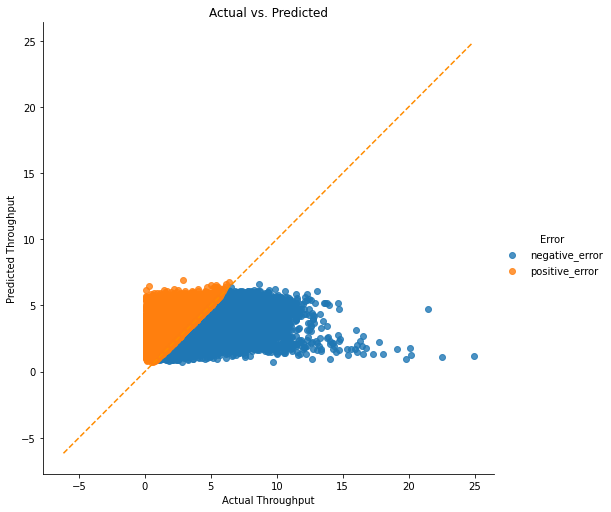

In [18]:
df_results_test= linear_assumption(model,X_test, y_test)

In [10]:
#from sklearn.preprocessing import PolynomialFeatures
features = ['DL_THROUGHPUT','DL_PRB_UTI','REFERENCESIGNALPWR','MAXIMUM_TRANSMIT_POWER','MIMO_RANK_2_PERCENTAGE','MIMO_RANK_3_PERCENTAGE','MIMO_RANK_4_PERCENTAGE']
n = 7
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(test_group[features].values, test_group.DL_TRAFFIC_GB.values, test_size=0.3, random_state=0)

# Transform features to polynomial features of degree 7
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train.reshape(-1, n))
X_test_poly = poly.transform(np.array(X_test).reshape(-1, n))
X = poly.transform(np.array(test_group[features]).reshape(-1, n)) 

print(X_train.shape)
print(X_train_poly.shape)
print(y_train.shape)
print(X_test_poly.shape)
print(y_test.shape)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)
y_pred = model.predict(X)

print(X.shape)
print(y_pred.shape)

# Calculate metrics
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_all = mean_squared_error( test_group.DL_TRAFFIC_GB.values, y_pred)
r2_all = r2_score( test_group.DL_TRAFFIC_GB.values, y_pred)

print("Train MSE:", mse_train)
print("Train R-squared:", r2_train)
print("Test MSE:", mse_test)
print("Test R-squared:", r2_test)
print("All MSE:", mse_all)
print("All R-squared:", r2_all)


(200266, 7)
(200266, 36)
(200266,)
(85829, 36)
(85829,)
(286095, 36)
(286095,)
Train MSE: 0.3200855585939258
Train R-squared: 0.9374821283195439
Test MSE: 0.3204230753148362
Test R-squared: 0.9370121619120904
All MSE: 0.3201868142000671
All R-squared: 0.9373417728282533


In [11]:

features = ['DL_THROUGHPUT','DL_PRB_UTI']
n = 2
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(test_group[features].values, test_group.DL_TRAFFIC_GB.values, test_size=0.3, random_state=0)

# Transform features to polynomial features of degree 7
poly2 = PolynomialFeatures(degree=2)
X_train_poly = poly2.fit_transform(X_train.reshape(-1, n))
X_test_poly = poly2.transform(np.array(X_test).reshape(-1, n))
X = poly2.transform(np.array(test_group[features]).reshape(-1, n)) 

print(X_train.shape)
print(X_train_poly.shape)
print(y_train.shape)
print(X_test_poly.shape)
print(y_test.shape)

# Fit a linear regression model
model2 = LinearRegression()
model2.fit(X_train_poly, y_train)

# Predict
y_train_pred = model2.predict(X_train_poly)
y_test_pred = model2.predict(X_test_poly)
y_pred = model2.predict(X)

print(X.shape)
print(y_pred.shape)

# Calculate metrics
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_all = mean_squared_error( test_group.DL_TRAFFIC_GB.values, y_pred)
r2_all = r2_score( test_group.DL_TRAFFIC_GB.values, y_pred)

print("Train MSE:", mse_train)
print("Train R-squared:", r2_train)
print("Test MSE:", mse_test)
print("Test R-squared:", r2_test)
print("All MSE:", mse_all)
print("All R-squared:", r2_all)


(200266, 2)
(200266, 6)
(200266,)
(85829, 6)
(85829,)
(286095, 6)
(286095,)
Train MSE: 0.5564000115527292
Train R-squared: 0.8913261045638504
Test MSE: 0.5581370385405718
Test R-squared: 0.8902830410078423
All MSE: 0.5569211226848342
All R-squared: 0.8910145931239811


In [ ]:
pickle.dump(model,open("/data/u_AA/throughput_opt/traffic_model_const.pickle",'wb'))
pickle.dump(model2,open("/data/u_AA/throughput_opt/traffic_model_prb.pickle",'wb'))
pickle.dump(poly2,open("/data/u_AA/throughput_opt/transoformer_prb.pickle",'wb'))
pickle.dump(poly,open("/data/u_AA/throughput_opt/transoformer_const.pickle",'wb'))

In [19]:
test_group.columns

Index(['DATE_ID', 'HOUR_ID', 'CELL_NAME', 'DL_TRAFFIC_GB', 'DL_THROUGHPUT',
       'UL_THROUGHPUT', 'UL_TRAFFIC_GB', 'DL_PRB_UTI', 'CCE_UTI',
       'VOLTE_DL_TRAFFIC_ERL', 'VOLTE_DL_TRAFFIC_MB', 'VOLTE_UL_TRAFFIC_MB',
       'AVG_ACTIVE_UE_DL', 'PRB_DL_AVAILABLE', 'CQI_AVERAGE',
       'MIMO_RANK_2_PERCENTAGE', 'MIMO_RANK_3_PERCENTAGE',
       'MIMO_RANK_4_PERCENTAGE', 'MAXMIMORANKPARA', 'REFERENCESIGNALPWR',
       'MAXIMUM_TRANSMIT_POWER', 'band', 'band_letter'],
      dtype='object')

In [20]:
sim_output1=test_group.copy()
sim_output2=test_group.copy()

In [21]:
sim_output1['new_throughput']= sim_output1.DL_THROUGHPUT+1


In [22]:
features = ['DL_THROUGHPUT','DL_PRB_UTI']
n=2
X = poly2.transform(np.array(sim_output1[features]).reshape(-1, n)) 
y_pred = model2.predict(X)
sim_output1['pred_traffic']=y_pred

In [23]:
sim_output1.columns


Index(['DATE_ID', 'HOUR_ID', 'CELL_NAME', 'DL_TRAFFIC_GB', 'DL_THROUGHPUT',
       'UL_THROUGHPUT', 'UL_TRAFFIC_GB', 'DL_PRB_UTI', 'CCE_UTI',
       'VOLTE_DL_TRAFFIC_ERL', 'VOLTE_DL_TRAFFIC_MB', 'VOLTE_UL_TRAFFIC_MB',
       'AVG_ACTIVE_UE_DL', 'PRB_DL_AVAILABLE', 'CQI_AVERAGE',
       'MIMO_RANK_2_PERCENTAGE', 'MIMO_RANK_3_PERCENTAGE',
       'MIMO_RANK_4_PERCENTAGE', 'MAXMIMORANKPARA', 'REFERENCESIGNALPWR',
       'MAXIMUM_TRANSMIT_POWER', 'band', 'band_letter', 'new_throughput',
       'pred_traffic'],
      dtype='object')

In [24]:
sim_output1[['new_throughput','DL_THROUGHPUT','DL_PRB_UTI','DL_TRAFFIC_GB','pred_traffic']].head(10)

new_throughput  DL_THROUGHPUT  DL_PRB_UTI  DL_TRAFFIC_GB  pred_traffic
30          5.8313         4.8313      74.422         6.2106      5.436843
31          9.1491         8.1491      58.455         3.3086      4.527528
32          8.4628         7.4628      66.575         3.5287      5.343630
33          5.4452         4.4452      58.071         3.4496      3.415965
34          6.0429         5.0429      40.831         1.9185      1.983506
35          7.1198         6.1198      44.815         2.7840      2.550825
36         11.7846        10.7846      54.526         5.4336      4.764987
43         21.6368        20.6368      29.660         2.7634      3.340372
44         14.5447        13.5447      59.570         7.1722      6.252984
45          8.8894         7.8894      65.749         4.6223      5.375480

In [25]:
sim_output2['new_throughput']= sim_output2.DL_THROUGHPUT+1
features = ['DL_THROUGHPUT','DL_PRB_UTI','REFERENCESIGNALPWR','MAXIMUM_TRANSMIT_POWER','MIMO_RANK_2_PERCENTAGE','MIMO_RANK_3_PERCENTAGE','MIMO_RANK_4_PERCENTAGE']
n = 7
X = poly.transform(np.array(sim_output2[features]).reshape(-1, n)) 
y_pred = model.predict(X)
sim_output2['pred_traffic']=y_pred

In [26]:
sim_output1.shape

(286095, 25)

In [27]:
sim_output1['diff']=sim_output1.DL_TRAFFIC_GB- sim_output1.pred_traffic
sim_output2['diff']=sim_output2.DL_TRAFFIC_GB- sim_output2.pred_traffic

In [29]:
sim_output1['diff'].describe()

count    286095.000000
mean         -0.001381
std           0.746272
min         -14.345267
25%          -0.261129
50%          -0.017816
75%           0.195849
max          12.929904
Name: diff, dtype: float64

In [30]:
sim_output2['diff'].describe()

count    286095.000000
mean         -0.000114
std           0.565852
min         -12.133175
25%          -0.202378
50%          -0.004679
75%           0.197521
max          13.101128
Name: diff, dtype: float64

In [31]:
sim_output1[sim_output1['diff']<=-0.4].shape

(52076, 26)

In [32]:
sim_output2[sim_output2['diff']<=-0.4].shape

(39334, 26)

In [18]:
output=pd.read_parquet("/data/u_AA/throughput_opt/cells_traffic_T_const_final.parquet")

In [19]:
output.head(10)

CELL_NAME             DATE_ID  DL_THROUGHPUT  DL_TRAFFIC_GB  \
30  LCAI2006_39842_N_H_T4_2  29-MAR-24 00.00.00         4.8313         6.2106   
31  LCAI2006_39843_N_H_T4_3  29-MAR-24 00.00.00         8.1491         3.3086   
32  LCAI2006_39844_N_H_T4_4  29-MAR-24 00.00.00         7.4628         3.5287   
33  LCAI2006_39847_N_H_T8_2  29-MAR-24 00.00.00         4.4452         3.4496   
34  LCAI2006_39848_N_H_T8_3  29-MAR-24 00.00.00         5.0429         1.9185   
35  LCAI2006_39849_N_H_T8_4  29-MAR-24 00.00.00         6.1198         2.7840   
36  LCAI2010_48058_N_H_T8_3  29-MAR-24 00.00.00        10.7846         5.4336   
43  LCAI2011_39476_N_H_T8_1  29-MAR-24 00.00.00        20.6368         2.7634   
44  LCAI2011_39477_N_H_T8_2  29-MAR-24 00.00.00        13.5447         7.1722   
45  LCAI2011_39478_N_H_T8_3  29-MAR-24 00.00.00         7.8894         4.6223   

    throughput_0  throughput_1  throughput_2  throughput_3  throughput_4  \
30      5.641132      5.888487      6.136012      6.383707      6.631572   
31      3.846030      4.044934      4.244009      4.443253      4.642668   
32      4.087219      4.315069      4.543089      4.771280      4.999640   
33      3.523836      3.719235      3.914805      4.110544      4.306454   
34      1.876663      2.018254      2.160016      2.301947      2.444049   
35      2.796818      2.948124      3.099600      3.251246      3.403063   
36      4.894344      5.076617      5.259061      5.441674      5.624458   
43      3.004482      3.108643      3.212974      3.317475      3.422147   
44      6.542129      6.738906      6.935853      7.132971      7.330259   
45      5.211999      5.432031      5.652232      5.872604      6.093146   

    throughput_5  throughput_6  throughput_7  throughput_8  throughput_9  \
30      6.879607      7.127813      7.376188      7.624734      7.873450   
31      4.842252      5.042007      5.241932      5.442027      5.642293   
32      5.228171      5.456871      5.685742      5.914783      6.143994   
33      4.502533      4.698783      4.895203      5.091793      5.288554   
34      2.586321      2.728763      2.871375      3.014157      3.157110   
35      3.555049      3.707206      3.859533      4.012030      4.164697   
36      5.807412      5.990536      6.173830      6.357295      6.540929   
43      3.526988      3.632000      3.737182      3.842534      3.948056   
44      7.527716      7.725344      7.923142      8.121111      8.319249   
45      6.313858      6.534740      6.755792      6.977014      7.198407   

    throughput_10  throughput_11  throughput_12  throughput_13  throughput_14  \
30       8.122336       8.371392       8.620618       8.870014       9.119581   
31       5.842728       6.043334       6.244110       6.445056       6.646172   
32       6.373376       6.602927       6.832649       7.062541       7.292603   
33       5.485484       5.682585       5.879856       6.077297       6.274908   
34       3.300232       3.443525       3.586988       3.730621       3.874424   
35       4.317534       4.470541       4.623719       4.777067       4.930585   
36       6.724734       6.908709       7.092854       7.277169       7.461654   
43       4.053748       4.159611       4.265643       4.371846       4.478219   
44       8.517558       8.716036       8.914685       9.113504       9.312493   
45       7.419970       7.641702       7.863605       8.085679       8.307922   

    throughput_15  throughput_16  throughput_17  throughput_18  throughput_19  \
30       9.369318       9.619225       9.869302      10.119549      10.369966   
31       6.847458       7.048914       7.250541       7.452337       7.654304   
32       7.522835       7.753237       7.983809       8.214552       8.445464   
33       6.472689       6.670640       6.868762       7.067053       7.265515   
34       4.018398       4.162541       4.306855       4.451339       4.595993   
35       5.084273       5.238131       5.392159       5.546358       5.700

In [14]:
output2=pd.read_parquet("/data/u_AA/throughput_opt/cells_traffic_T_prb_final.parquet")

In [15]:
output2.head(10)

CELL_NAME             DATE_ID  DL_THROUGHPUT  DL_TRAFFIC_GB  \
30  LCAI2006_39842_N_H_T4_2  29-MAR-24 00.00.00         4.8313         6.2106   
31  LCAI2006_39843_N_H_T4_3  29-MAR-24 00.00.00         8.1491         3.3086   
32  LCAI2006_39844_N_H_T4_4  29-MAR-24 00.00.00         7.4628         3.5287   
33  LCAI2006_39847_N_H_T8_2  29-MAR-24 00.00.00         4.4452         3.4496   
34  LCAI2006_39848_N_H_T8_3  29-MAR-24 00.00.00         5.0429         1.9185   
35  LCAI2006_39849_N_H_T8_4  29-MAR-24 00.00.00         6.1198         2.7840   
36  LCAI2010_48058_N_H_T8_3  29-MAR-24 00.00.00        10.7846         5.4336   
43  LCAI2011_39476_N_H_T8_1  29-MAR-24 00.00.00        20.6368         2.7634   
44  LCAI2011_39477_N_H_T8_2  29-MAR-24 00.00.00        13.5447         7.1722   
45  LCAI2011_39478_N_H_T8_3  29-MAR-24 00.00.00         7.8894         4.6223   

    throughput_0  throughput_1  throughput_2  throughput_3  throughput_4  \
30      5.436843      5.809353      6.181662      6.553771      6.925679   
31      4.527528      4.816484      5.105241      5.393796      5.682151   
32      5.343630      5.674877      6.005923      6.336769      6.667414   
33      3.415965      3.703671      3.991177      4.278482      4.565586   
34      1.983506      2.181596      2.379486      2.577176      2.774665   
35      2.550825      2.769381      2.987737      3.205892      3.423846   
36      4.764987      5.033019      5.300851      5.568482      5.835912   
43      3.340372      3.477344      3.614116      3.750687      3.887057   
44      6.252984      6.546647      6.840109      7.133370      7.426431   
45      5.375480      5.702353      6.029026      6.355498      6.681770   

    throughput_5  throughput_6  throughput_7  throughput_8  throughput_9  \
30      7.297386      7.668893      8.040200      8.411305      8.782211   
31      5.970306      6.258260      6.546013      6.833566      7.120918   
32      6.997859      7.328103      7.658146      7.987989      8.317631   
33      4.852490      5.139194      5.425697      5.711999      5.998101   
34      2.971953      3.169041      3.365928      3.562614      3.759100   
35      3.641600      3.859153      4.076506      4.293658      4.510610   
36      6.103142      6.370171      6.636999      6.903627      7.170055   
43      4.023227      4.159196      4.294965      4.430532      4.565900   
44      7.719292      8.011952      8.304411      8.596669      8.888727   
45      7.007841      7.333711      7.659381      7.984850      8.310119   

    throughput_10  throughput_11  throughput_12  throughput_13  throughput_14  \
30       9.152915       9.523419       9.893723      10.263825      10.633728   
31       7.408069       7.695020       7.981771       8.268321       8.554670   
32       8.647072       8.976313       9.305354       9.634194       9.962833   
33       6.284002       6.569702       6.855202       7.140502       7.425600   
34       3.955385       4.151470       4.347354       4.543038       4.738521   
35       4.727361       4.943911       5.160261       5.376410       5.592359   
36       7.436282       7.702308       7.968133       8.233758       8.499183   
43       4.701067       4.836033       4.970799       5.105364       5.239728   
44       9.180585       9.472242       9.763698      10.054954      10.346009   
45       8.635187       8.960054       9.284721       9.609188       9.933453   

    throughput_15  throughput_16  throughput_17  throughput_18  throughput_19  \
30      11.003429      11.372930      11.742231      12.111331      12.480230   
31       8.840819       9.126767       9.412514       9.698061       9.983407   
32      10.291272      10.619510      10.947547      11.275384      11.603020   
33       7.710499       7.995196       8.279693       8.563990       8.848085   
34       4.933803       5.128885       5.323766       5.518447       5.712927   
35       5.808107       6.023654       6.239001       6.454147       6.669

In [16]:
output.describe()

NameError: name 'output' is not defined

In [7]:
output2.describe()

DL_THROUGHPUT  DL_TRAFFIC_GB   throughput_1   throughput_2  \
count  286095.000000  286095.000000  286095.000000  286095.000000   
mean       12.684319       3.228844       3.431326       3.632227   
std         9.514144       2.260546       2.258356       2.383114   
min         0.000000       0.100100      -2.222058      -2.251964   
25%         6.104850       1.439550       1.602767       1.698819   
50%         9.976100       2.819500       3.123119       3.308978   
75%        16.458150       4.608100       5.063469       5.365875   
max       176.062700      24.942200      33.057278      33.510646   

        throughput_3   throughput_4   throughput_5   throughput_6  \
count  286095.000000  286095.000000  286095.000000  286095.000000   
mean        3.832927       4.033426       4.233725       4.433823   
std         2.508837       2.635384       2.762645       2.890523   
min        -2.282071      -2.312379      -2.342887      -2.373596   
25%         1.793826       1.887425       1.979406       2.070180   
50%         3.494748       3.679860       3.864734       4.049679   
75%         5.667586       5.968431       6.267940       6.571713   
max        33.963813      34.416780      34.869546      35.322112   

        throughput_7   throughput_8   throughput_9  throughput_10  \
count  286095.000000  286095.000000  286095.000000  286095.000000   
mean        4.633721       4.833418       5.032915       5.232210   
std         3.018941       3.147832       3.277142       3.406821   
min        -2.404505      -2.435615      -2.466925      -2.498436   
25%         2.163369       2.254536       2.344961       2.435603   
50%         4.232788       4.417059       4.601760       4.784389   
75%         6.874034       7.177092       7.479295       7.782425   
max        35.774477      36.226641      36.678605      37.130368   

       throughput_11  throughput_12  throughput_13  throughput_14  \
count  286095.000000  286095.000000  286095.000000  286095.000000   
mean        5.431306       5.630201       5.828895       6.027388   
std         3.536830       3.667133       3.797700       3.928505   
min        -2.530148      -2.562060      -2.594173      -2.626487   
25%         2.523192       2.612859       2.699383       2.788177   
50%         4.968623       5.149524       5.331022       5.514001   
75%         8.083400       8.384734       8.686880       8.987681   
max        37.581931      38.033293      38.484454      38.935415   

       throughput_15  throughput_16  throughput_17  throughput_18  \
count  286095.000000  286095.000000  286095.000000  286095.000000   
mean        6.225681       6.423774       6.621666       6.819357   
std         4.059525       4.190739       4.322131       4.453683   
min        -2.659001      -2.691715      -2.724630      -2.757746   
25%         2.875235       2.961439       3.047828       3.133776   
50%         5.696105       5.878026       6.060452       6.241583   
75%         9.289558       9.586514       9.887480      10.186873   
max        39.386176      39.836735      40.287094      40.737253   

       throughput_19  throughput_20  
count  286095.000000  286095.000000  
mean        7.016848       7.214138  
std         4.585383       4.717218  
min        -2.791062      -2.824579  
25%         3.219196       3.304661  
50%         6.423634       6.605219  
75%        10.488483      10.789690  
max        41.187211      41.636968

In [9]:
(output.iloc[:,4:] < 0).sum()

throughput_1     3175
throughput_2     2928
throughput_3     2734
throughput_4     2542
throughput_5     2359
throughput_6     2200
throughput_7     2055
throughput_8     1923
throughput_9     1769
throughput_10    1661
throughput_11    1543
throughput_12    1435
throughput_13    1340
throughput_14    1243
throughput_15    1161
throughput_16    1089
throughput_17    1027
throughput_18     958
throughput_19     887
throughput_20     828
dtype: int64

In [10]:
(output2.iloc[:,4:] < 0).sum()

throughput_1     2320
throughput_2     2364
throughput_3     2432
throughput_4     2488
throughput_5     2563
throughput_6     2620
throughput_7     2672
throughput_8     2744
throughput_9     2805
throughput_10    2872
throughput_11    2932
throughput_12    2997
throughput_13    3058
throughput_14    3133
throughput_15    3213
throughput_16    3274
throughput_17    3330
throughput_18    3403
throughput_19    3477
throughput_20    3534
dtype: int64

In [18]:
output.columns[1:]

Index(['DATE_ID', 'DL_THROUGHPUT', 'DL_TRAFFIC_GB', 'throughput_1',
       'throughput_2', 'throughput_3', 'throughput_4', 'throughput_5',
       'throughput_6', 'throughput_7', 'throughput_8', 'throughput_9',
       'throughput_10', 'throughput_11', 'throughput_12', 'throughput_13',
       'throughput_14', 'throughput_15', 'throughput_16', 'throughput_17',
       'throughput_18', 'throughput_19', 'throughput_20'],
      dtype='object')

In [39]:
cell_data1= output.groupby(['CELL_NAME'])[output.columns[1:]].mean().reset_index()

In [40]:
cell_data1.head()

CELL_NAME  DL_THROUGHPUT  DL_TRAFFIC_GB  throughput_0  \
0  LALX3005_50051_N_H_T4_1      22.923753       4.468840      4.169348   
1  LALX3005_50052_N_H_T4_2      24.040553       1.723573      1.724182   
2  LALX3005_50053_N_H_T4_3      30.458855       0.805541      0.901188   
3  LALX3005_50056_N_H_T8_1      18.836304       1.559970      1.635235   
4  LALX3005_50057_N_H_T8_2      26.614835       0.901057      0.974449   

   throughput_1  throughput_2  throughput_3  throughput_4  throughput_5  \
0      4.298737      4.428296      4.558025      4.687924      4.817994   
1      1.794353      1.864694      1.935205      2.005886      2.076737   
2      0.936627      0.972237      1.008016      1.043966      1.080086   
3      1.707389      1.779713      1.852208      1.924872      1.997707   
4      1.012484      1.050688      1.089063      1.127608      1.166323   

   throughput_6  throughput_7  throughput_8  throughput_9  throughput_10  \
0      4.948233      5.078643      5.209223      5.339973       5.470893   
1      2.147759      2.218950      2.290312      2.361844       2.433546   
2      1.116376      1.152837      1.189467      1.226268       1.263238   
3      2.070712      2.143887      2.217232      2.290748       2.364433   
4      1.205208      1.244263      1.283488      1.322884       1.362450   

   throughput_11  throughput_12  throughput_13  throughput_14  throughput_15  \
0       5.601983       5.733244       5.864675       5.996275       6.128046   
1       2.505418       2.577460       2.649673       2.722056       2.794608   
2       1.300379       1.337690       1.375172       1.412823       1.450644   
3       2.438289       2.512315       2.586511       2.660877       2.735413   
4       1.402186       1.442092       1.482168       1.522414       1.562830   

   throughput_16  throughput_17  throughput_18  throughput_19  throughput_20  
0       6.259988       6.392099       6.524380       6.656832       6.789453  
1       2.867331       2.940224       3.013288       3.086521       3.159925  
2       1.488636       1.526798       1.565130       1.603632       1.642304  
3       2.810120       2.884996       2.960043       3.035260       3.110647  
4       1.603417       1.644174       1.685101       1.726198       1.767465

In [41]:
cell_data1['region']=cell_data1.CELL_NAME.str.upper().str[1:4]

In [47]:
total_per_region=cell_data1.groupby(['region'])[cell_data1.columns[1:]].sum()

In [43]:
#total_per_region.set_index(['region'],inplace=True)

In [48]:
total_per_region.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, ALX to UPP
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DL_THROUGHPUT  5 non-null      float64
 1   DL_TRAFFIC_GB  5 non-null      float64
 2   throughput_0   5 non-null      float64
 3   throughput_1   5 non-null      float64
 4   throughput_2   5 non-null      float64
 5   throughput_3   5 non-null      float64
 6   throughput_4   5 non-null      float64
 7   throughput_5   5 non-null      float64
 8   throughput_6   5 non-null      float64
 9   throughput_7   5 non-null      float64
 10  throughput_8   5 non-null      float64
 11  throughput_9   5 non-null      float64
 12  throughput_10  5 non-null      float64
 13  throughput_11  5 non-null      float64
 14  throughput_12  5 non-null      float64
 15  throughput_13  5 non-null      float64
 16  throughput_14  5 non-null      float64
 17  throughput_15  5 non-null      float64
 18  throughput_16  

In [49]:
total_per_region.reset_index(drop=True,inplace=True)

DL_THROUGHPUT  DL_TRAFFIC_GB  throughput_0  throughput_1  \
region                                                             
ALX      41081.003910    3740.731740   3838.359533   3993.433763   
CAI      24570.665796   12100.523954  12162.869860  12697.411911   
DEL       3100.358651     810.126186    797.754422    826.972210   
SIN      23818.504532    1708.433711   1721.033736   1789.868673   
UPP      39712.787936   12888.494767  12727.016428  13305.659322   

        throughput_2  throughput_3  throughput_4  throughput_5  throughput_6  \
region                                                                         
ALX      4148.858670   4304.634254   4460.760514   4617.237451   4774.065065   
CAI     13232.429017  13767.921179  14303.888396  14840.330669  15377.247998   
DEL       856.226750    885.518042    914.846086    944.210882    973.612431   
SIN      1858.885499   1928.084215   1997.464819   2067.027312   2136.771695   
UPP     13884.967157  14464.939933  15045.577652  15626.880312  16208.847913   

        throughput_7  throughput_8  throughput_9  throughput_10  \
region                                                            
ALX      4931.243356   5088.772324   5246.651968    5404.882289   
CAI     15914.640382  16452.507822  16990.850317   17529.667868   
DEL      1003.050731   1032.525784   1062.037589    1091.586146   
SIN      2206.697966   2276.806127   2347.096177    2417.568116   
UPP     16791.480457  17374.777942  17958.740368   18543.367737   

        throughput_11  throughput_12  throughput_13  throughput_14  \
region                                                               
ALX       5563.463286    5722.394961    5881.677312    6041.310340   
CAI      18068.960474   18608.728136   19148.970853   19689.688626   
DEL       1121.171455    1150.793517    1180.452330    1210.147896   
SIN       2488.221944    2559.057661    2630.075267    2701.274762   
UPP      19128.660047   19714.617298   20301.239492   20888.526626   

        throughput_15  throughput_16  throughput_17  throughput_18  \
region                                                               
ALX       6201.294045    6361.628426    6522.313485    6683.349220   
CAI      20230.881455   20772.549339   21314.692279   21857.310274   
DEL       1239.880214    1269.649284    1299.455106    1329.297680   
SIN       2772.656147    2844.219420    2915.964583    2987.891635   
UPP      21476.478703   22065.095721   22654.377681   23244.324583   

        throughput_19  throughput_20  
region                                
ALX       6844.735631    7006.472720  
CAI      22400.403325   22943.971431  
DEL       1359.177007    1389.093085  
SIN       3060.000576    3132.291406  
UPP      23834.936426   24426.213211

In [50]:
result_per_region= pd.DataFrame()
result_per_region=total_per_region[['region','DL_THROUGHPUT','DL_TRAFFIC_GB']]

KeyError: "['region'] not in index"

In [29]:
result_per_region

region  DL_THROUGHPUT  DL_TRAFFIC_GB
0    ALX   41081.003910    3740.731740
1    CAI   24570.665796   12100.523954
2    DEL    3100.358651     810.126186
3    SIN   23818.504532    1708.433711
4    UPP   39712.787936   12888.494767

In [31]:
total_per_region.columns[3:]

Index(['throughput_1', 'throughput_2', 'throughput_3', 'throughput_4',
       'throughput_5', 'throughput_6', 'throughput_7', 'throughput_8',
       'throughput_9', 'throughput_10', 'throughput_11', 'throughput_12',
       'throughput_13', 'throughput_14', 'throughput_15', 'throughput_16',
       'throughput_17', 'throughput_18', 'throughput_19', 'throughput_20'],
      dtype='object')

In [34]:
result_per_region=pd.concat([result_per_region, total_per_region[total_per_region.columns[3:]].subtract(total_per_region['DL_TRAFFIC_GB'], axis=0)],axis=1)
result_per_region

region  DL_THROUGHPUT  DL_TRAFFIC_GB  throughput_1  throughput_2  \
0    ALX   41081.003910    3740.731740    252.702023    408.126930   
1    CAI   24570.665796   12100.523954    596.887957   1131.905063   
2    DEL    3100.358651     810.126186     16.846024     46.100563   
3    SIN   23818.504532    1708.433711     81.434963    150.451789   
4    UPP   39712.787936   12888.494767    417.164554    996.472390   

   throughput_3  throughput_4  throughput_5  throughput_6  throughput_7  \
0    563.902514    720.028774    876.505712   1033.333326   1190.511616   
1   1667.397225   2203.364442   2739.806715   3276.724044   3814.116428   
2     75.391855    104.719900    134.084696    163.486244    192.924545   
3    219.650504    289.031108    358.593602    428.337984    498.264256   
4   1576.445166   2157.082885   2738.385545   3320.353146   3902.985690   

   throughput_8  throughput_9  throughput_10  throughput_11  throughput_12  \
0   1348.040584   1505.920228    1664.150549    1822.731547    1981.663221   
1   4351.983868   4890.326363    5429.143914    5968.436520    6508.204182   
2    222.399598    251.911403     281.459960     311.045269     340.667331   
3    568.372416    638.662466     709.134405     779.788233     850.623950   
4   4486.283175   5070.245601    5654.872970    6240.165280    6826.122531   

   throughput_13  throughput_14  throughput_15  throughput_16  throughput_17  \
0    2140.945572    2300.578600    2460.562305    2620.896687    2781.581745   
1    7048.446899    7589.164672    8130.357501    8672.025385    9214.168325   
2     370.326144     400.021710     429.754028     459.523098     489.328920   
3     921.641557     992.841052    1064.222436    1135.785710    1207.530873   
4    7412.744724    8000.031859    8587.983936    9176.600954    9765.882914   

   throughput_18  throughput_19  throughput_20  
0    2942.617480    3104.003892    3265.740980  
1    9756.786320   10299.879371   10843.447477  
2     519.171494     549.050820     578.966899  
3    1279.457924    1351.566865    1423.857695  
4   10355.829816   10946.441659   11537.718444

In [51]:
cell_data2= output2.groupby(['CELL_NAME'])[output2.columns[1:]].mean().reset_index()
cell_data2['region']=cell_data2.CELL_NAME.str.upper().str[1:4]
# total_per_region2=cell_data2.groupby(['region'])[cell_data1.columns[1:]].sum()
# total_per_region2.set_index(['region'],inplace=True)
# result_per_region2= pd.DataFrame()
# result_per_region2=total_per_region2[['region','DL_THROUGHPUT','DL_TRAFFIC_GB']]
# result_per_region2=pd.concat([result_per_region2, total_per_region2[total_per_region2.columns[3:]].subtract(total_per_region2['DL_TRAFFIC_GB'], axis=0)],axis=1)
# result_per_region2

In [52]:
cell_data2.head(5)

CELL_NAME  DL_THROUGHPUT  DL_TRAFFIC_GB  throughput_0  \
0  LALX3005_50051_N_H_T4_1      22.923753       4.468840      4.982198   
1  LALX3005_50052_N_H_T4_2      24.040553       1.723573      1.895008   
2  LALX3005_50053_N_H_T4_3      30.458855       0.805541      0.985252   
3  LALX3005_50056_N_H_T8_1      18.836304       1.559970      1.819430   
4  LALX3005_50057_N_H_T8_2      26.614835       0.901057      0.969930   

   throughput_1  throughput_2  throughput_3  throughput_4  throughput_5  \
0      5.155381      5.328363      5.501144      5.673725      5.846105   
1      1.974972      2.054736      2.134298      2.213660      2.292822   
2      1.017750      1.050048      1.082145      1.114042      1.145738   
3      1.905747      1.991864      2.077779      2.163495      2.249009   
4      1.004379      1.038627      1.072675      1.106522      1.140169   

   throughput_6  throughput_7  throughput_8  throughput_9  throughput_10  \
0      6.018284      6.190263      6.362041      6.533619       6.704996   
1      2.371783      2.450543      2.529103      2.607462       2.685621   
2      1.177234      1.208528      1.239623      1.270516       1.301210   
3      2.334324      2.419437      2.504350      2.589062       2.673574   
4      1.173615      1.206861      1.239906      1.272750       1.305394   

   throughput_11  throughput_12  throughput_13  throughput_14  throughput_15  \
0       6.876173       7.047149       7.217924       7.388499       7.558873   
1       2.763579       2.841336       2.918893       2.996249       3.073405   
2       1.331702       1.361994       1.392085       1.421976       1.451666   
3       2.757885       2.841996       2.925906       3.009615       3.093124   
4       1.337837       1.370080       1.402122       1.433964       1.465605   

   throughput_16  throughput_17  throughput_18  throughput_19  throughput_20  \
0       7.729047       7.899020       8.068793       8.238364       8.407736   
1       3.150360       3.227114       3.303668       3.380022       3.456174   
2       1.481156       1.510445       1.539533       1.568421       1.597109   
3       3.176433       3.259540       3.342447       3.425154       3.507660   
4       1.497045       1.528285       1.559324       1.590162       1.620800   

  region  
0    ALX  
1    ALX  
2    ALX  
3    ALX  
4    ALX

In [55]:
total_per_region2=cell_data2.groupby(['region'])[cell_data1.columns[1:]].sum().reset_index()
result_per_region2= pd.DataFrame()
result_per_region2=total_per_region2[['region','DL_THROUGHPUT','DL_TRAFFIC_GB']]
#result_per_region2=pd.concat([result_per_region2, total_per_region2[total_per_region2.columns[3:]].subtract(total_per_region2['DL_TRAFFIC_GB'], axis=0)],axis=1)
total_per_region2

region  DL_THROUGHPUT  DL_TRAFFIC_GB  throughput_0  throughput_1  \
0    ALX   41081.003910    3740.731740   3945.631791   4144.150588   
1    CAI   24570.665796   12100.523954  12359.143430  13144.913548   
2    DEL    3100.358651     810.126186    734.174944    776.132400   
3    SIN   23818.504532    1708.433711   1694.837696   1778.011366   
4    UPP   39712.787936   12888.494767  12489.133113  13321.763673   

   throughput_2  throughput_3  throughput_4  throughput_5  throughput_6  \
0   4342.255981   4539.947969   4737.226553   4934.091733   5130.543508   
1  13930.123635  14714.773690  15498.863714  16282.393706  17065.363667   
2    818.046529    859.917333    901.744811    943.528962    985.269787   
3   1860.970611   1943.715431   2026.245827   2108.561798   2190.663344   
4  14153.610349  14984.673142  15814.952051  16644.447076  17473.158217   

   throughput_7  throughput_8  throughput_9  throughput_10  throughput_11  \
0   5326.581879   5522.206846   5717.418408    5912.216566    6106.601319   
1  17847.773596  18629.623494  19410.913360   20191.643195   20971.812998   
2   1026.967285   1068.621458   1110.232304    1151.799824    1193.324018   
3   2272.550466   2354.223163   2435.681435    2516.925283    2597.954706   
4  18301.085475  19128.228850  19954.588340   20780.163947   21604.955670   

   throughput_12  throughput_13  throughput_14  throughput_15  throughput_16  \
0    6300.572669    6494.130613    6687.275154    6880.006290    7072.324022   
1   21751.422769   22530.472509   23308.962218   24086.891895   24864.261541   
2    1234.804886    1276.242427    1317.636643    1358.987532    1400.295094   
3    2678.769704    2759.370277    2839.756426    2919.928151    2999.885450   
4   22428.963510   23252.187466   24074.627538   24896.283727   25717.156032   

   throughput_17  throughput_18  throughput_19  throughput_20  
0    7264.228349    7455.719272    7646.796791    7837.460905  
1   25641.071155   26417.320737   27193.010288   27968.139808  
2    1441.559331    1482.780241    1523.957825    1565.092083  
3    3079.628325    3159.156775    3238.470801    3317.570402  
4   26537.244453   27356.548991   28175.069645   28992.806415

In [46]:
result_per_region2

region  DL_THROUGHPUT  DL_TRAFFIC_GB  throughput_1  throughput_2  \
0    ALX   41081.003910    3740.731740    403.418849    601.524241   
1    CAI   24570.665796   12100.523954   1044.389594   1829.599681   
2    DEL    3100.358651     810.126186    -33.993787      7.920343   
3    SIN   23818.504532    1708.433711     69.577655    152.536900   
4    UPP   39712.787936   12888.494767    433.268906   1265.115582   

   throughput_3  throughput_4  throughput_5  throughput_6  throughput_7  \
0    799.216230    996.494814   1193.359993   1389.811769   1585.850139   
1   2614.249736   3398.339760   4181.869752   4964.839713   5747.249642   
2     49.791147     91.618624    133.402776    175.143601    216.841099   
3    235.281721    317.812116    400.128087    482.229634    564.116755   
4   2096.178375   2926.457284   3755.952309   4584.663450   5412.590708   

   throughput_8  throughput_9  throughput_10  throughput_11  throughput_12  \
0   1781.475106   1976.686668    2171.484826    2365.869580    2559.840929   
1   6529.099540   7310.389406    8091.119240    8871.289044    9650.898815   
2    258.495272    300.106118     341.673638     383.197832     424.678700   
3    645.789452    727.247725     808.491572     889.520995     970.335993   
4   6239.734083   7066.093573    7891.669180    8716.460903    9540.468743   

   throughput_13  throughput_14  throughput_15  throughput_16  throughput_17  \
0    2753.398874    2946.543414    3139.274550    3331.592282    3523.496609   
1   10429.948555   11208.438264   11986.367941   12763.737587   13540.547201   
2     466.116241     507.510456     548.861345     590.168908     631.433145   
3    1050.936567    1131.322716    1211.494440    1291.451740    1371.194615   
4   10363.692699   11186.132771   12007.788960   12828.661265   13648.749686   

   throughput_18  throughput_19  throughput_20  
0    3714.987532    3906.065051    4096.729165  
1   14316.796783   15092.486334   15867.615854  
2     672.654055     713.831639     754.965897  
3    1450.723065    1530.037090    1609.136691  
4   14468.054224   15286.574878   16104.311648